In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Обучение и тестирование LeNet

In [2]:
# LeNet architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 71190223.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# model
net = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
# Training
for epoch in range(10):  #
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

print("Finished Training")

Epoch 1, Loss: 2.246303654235342
Epoch 2, Loss: 1.9019328557012025
Epoch 3, Loss: 1.6161617394298544
Epoch 4, Loss: 1.5103793964361596
Epoch 5, Loss: 1.4428130758692845
Epoch 6, Loss: 1.3805646472574804
Epoch 7, Loss: 1.3208015950591974
Epoch 8, Loss: 1.2747882242550326
Epoch 9, Loss: 1.2343924336726098
Epoch 10, Loss: 1.1991597604568658
Finished Training


Accuracy: 0.5611
Precision: 0.5666238510719893
Recall: 0.5611
F1-Score: 0.5528370617095624
Inference Time: 4.31 seconds


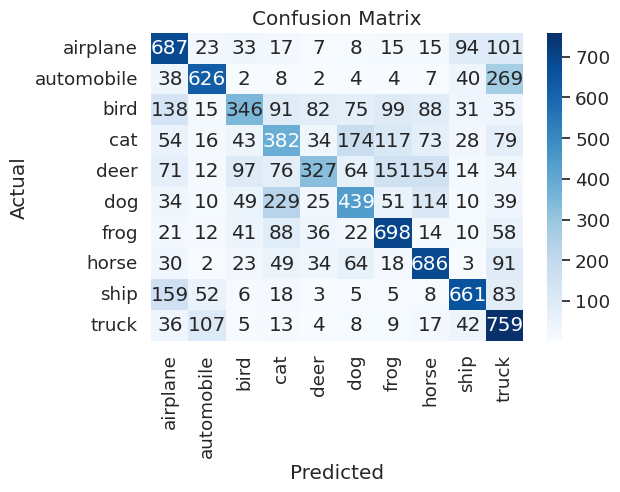

In [15]:
# Testing
def test_model(net):
    net.eval()
    all_labels = []
    all_predictions = []

    start_time = time.time()
    with torch.no_grad():
        for data in testloader:  #
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())
    end_time = time.time()

    # Metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    inference_time = end_time - start_time
    print(f"Inference Time: {inference_time:.2f} seconds")


    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=testset.classes, yticklabels=testset.classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

test_model(net)

In [8]:
torch.save(net, 'lenet_56.pt')

# Квантизация

Функция подсчета размера модели

In [11]:
import os

# save the model and check the model size
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size


## Post training quantization

### Dynamic quantization

In [16]:
import torch.quantization

In [17]:
quantized_net_dynamic = torch.quantization.quantize_dynamic(
    net,
    {nn.Conv2d, nn.Conv1d, nn.Linear}, dtype=torch.qint8
)

In [18]:
net

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
quantized_net_dynamic

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): DynamicQuantizedLinear(in_features=400, out_features=120, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=120, out_features=84, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc3): DynamicQuantizedLinear(in_features=84, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

Видим, что **квантовались только линейные слои**

In [21]:
f = print_size_of_model(net,"fp32")
q = print_size_of_model(quantized_net_dynamic,"int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 250.851
model:  int8  	 Size (KB): 76.095
3.30 times smaller


В 3.3 раза уменьшили размер модельки при сохранении методами pytorch

In [36]:
input = torch.rand(1, 3, 32, 32)

In [37]:
print("Floating point FP32: ")
%timeit net.forward(input)

print("Quantized INT8: ")
%timeit quantized_net_dynamic.forward(input)

Floating point FP32: 
732 µs ± 66.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Quantized INT8: 
570 µs ± 5.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Заметен прирост в скорости инференса в 1.28 раза

Accuracy: 0.5617
Precision: 0.5674770933258452
Recall: 0.5617
F1-Score: 0.5533197849853968
Inference Time: 4.87 seconds


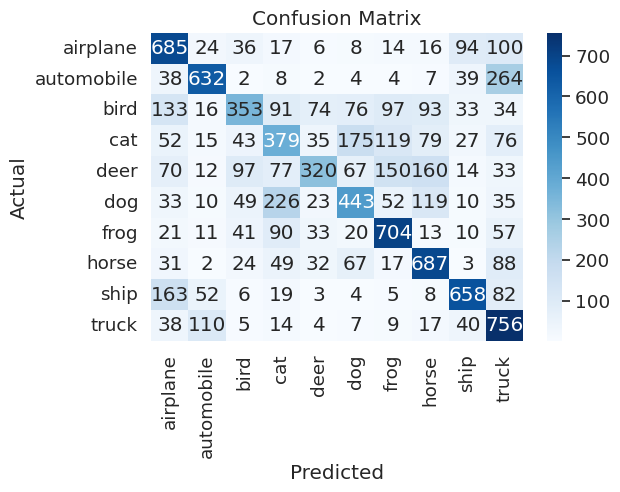

In [39]:
test_model(quantized_net_dynamic)

Качество не упало, но здесь качество не особо высокое.

### Static quantization

In [71]:
class LeNetQuant(torch.nn.Module):

    def __init__(self, net):
        super(LeNetQuant, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.net = net
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.net.pool(torch.relu(self.dequant(self.net.conv1(x))))
        x = self.net.pool(torch.relu(self.dequant(self.net.conv2(self.quant(x)))))
        x = x.reshape(-1, 16 * 5 * 5)
        x = torch.relu(self.net.fc1(self.quant(x)))
        x = torch.relu(self.net.fc2(x))
        x = self.dequant(self.net.fc3(x))
        return x

net_original = LeNetQuant(net)

In [72]:
net_original.eval()
net_original.qconfig = torch.quantization.get_default_qconfig('fbgemm')
quantized_net_static = torch.quantization.prepare(net_original)

quantized_net_static.eval()
for data, label in testloader:
    quantized_net_static(data)

torch.quantization.convert(quantized_net_static, inplace=True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


LeNetQuant(
  (quant): Quantize(scale=tensor([0.1363]), zero_point=tensor([16]), dtype=torch.quint8)
  (net): LeNet(
    (conv1): QuantizedConv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.18446169793605804, zero_point=59)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): QuantizedConv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=0.2488650679588318, zero_point=45)
    (fc1): QuantizedLinear(in_features=400, out_features=120, scale=0.2703699469566345, zero_point=74, qscheme=torch.per_channel_affine)
    (fc2): QuantizedLinear(in_features=120, out_features=84, scale=0.1321820467710495, zero_point=55, qscheme=torch.per_channel_affine)
    (fc3): QuantizedLinear(in_features=84, out_features=10, scale=0.17431950569152832, zero_point=63, qscheme=torch.per_channel_affine)
  )
  (dequant): DeQuantize()
)

Видим, что **квантовались еще и свертки**

In [73]:
f = print_size_of_model(net_original,"fp32")
q = print_size_of_model(quantized_net_static,"int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 250.979
model:  int8  	 Size (KB): 75.039
3.34 times smaller


Модель стала меньше в 3.34 раза по отношению к оригинальное

In [76]:
print("Floating point FP32: ")
%timeit net.forward(input)

print("Quantized INT8: ")
%timeit quantized_net_static.forward(input)

Floating point FP32: 
676 µs ± 109 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Quantized INT8: 
632 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Модель стала немного быстрее. Здесь часто приходится переводить картинки в квантованные и обратно

Accuracy: 0.5642
Precision: 0.5693574830336008
Recall: 0.5642
F1-Score: 0.5570618089995953
Inference Time: 10.01 seconds


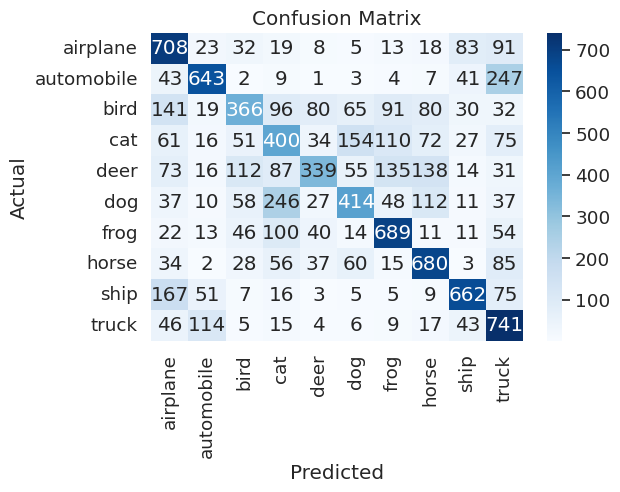

In [77]:
test_model(quantized_net_static)

Качество опять не упало. Это связано с тем, что оно изначально было невысокое

## Quantization aware training

In [78]:
net_original.train()
net_original.qconfig = torch.quantization.get_default_qconfig('fbgemm')
quantized_model_aware_training = torch.quantization.prepare_qat(net_original)

# train the model
quantized_model_aware_training.train()
optimizer = torch.optim.SGD(net_original.parameters(), lr=0.001, momentum=0.9)
for data, label in trainloader:
    optimizer.zero_grad()
    pred = quantized_model_aware_training(data)
    loss = criterion(pred, label)
    loss.backward()
    optimizer.step()

quantized_model_aware_training.eval()
torch.quantization.convert(quantized_model_aware_training, inplace=True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


LeNetQuant(
  (quant): Quantize(scale=tensor([0.1312]), zero_point=tensor([16]), dtype=torch.quint8)
  (net): LeNet(
    (conv1): QuantizedConv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.18444620072841644, zero_point=61)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): QuantizedConv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=0.235536590218544, zero_point=46)
    (fc1): QuantizedLinear(in_features=400, out_features=120, scale=0.2570623755455017, zero_point=75, qscheme=torch.per_channel_affine)
    (fc2): QuantizedLinear(in_features=120, out_features=84, scale=0.12776361405849457, zero_point=55, qscheme=torch.per_channel_affine)
    (fc3): QuantizedLinear(in_features=84, out_features=10, scale=0.16120384633541107, zero_point=58, qscheme=torch.per_channel_affine)
  )
  (dequant): DeQuantize()
)

Опять видим, что **заквантовались все слои**

In [93]:
f = print_size_of_model(net,"fp32")
q = print_size_of_model(quantized_model_aware_training,"int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 499.077
model:  int8  	 Size (KB): 75.039
6.65 times smaller


Опять видим, что **модель уменьшилась в 3.34 раза**

Accuracy: 0.5654
Precision: 0.5717457530041782
Recall: 0.5654
F1-Score: 0.5582547200626297
Inference Time: 6.18 seconds


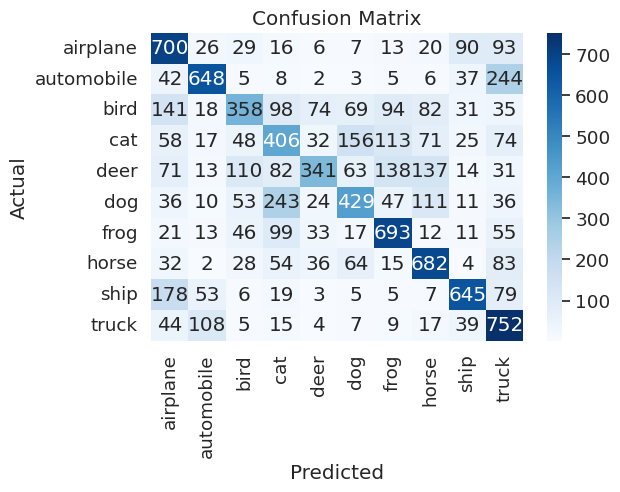

In [84]:
test_model(quantized_model_aware_training)

Точность чуть-чуть подросла)

# Прунинг
Прунинг с трешхолдом

In [89]:
from torch.nn.utils import prune

In [85]:
net

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [87]:
for w in net.named_parameters():
    print(w)

('conv1.weight', Parameter containing:
tensor([[[[-7.6001e-02, -1.2725e-01, -1.7115e-01, -1.0266e-01, -1.1902e-01],
          [ 3.4435e-02, -2.4983e-02, -1.5405e-01, -1.7696e-01, -1.2382e-01],
          [-1.4413e-01, -1.8198e-01, -1.9245e-01, -1.5352e-01, -1.6964e-01],
          [ 5.9733e-03, -1.2863e-01, -8.0265e-02, -9.3055e-02, -1.8107e-01],
          [ 1.4169e-02, -1.6665e-01, -1.1809e-01, -1.1284e-01, -1.5390e-01]],

         [[ 2.9291e-02, -3.4620e-02,  8.5675e-02,  1.9049e-02, -6.0148e-02],
          [-1.5652e-02,  1.3365e-01,  1.0065e-01,  4.4953e-02, -3.1869e-02],
          [-5.1579e-02, -2.2757e-02, -5.7065e-02,  5.6043e-02, -8.7638e-02],
          [ 1.4400e-01,  3.3260e-02,  6.2131e-02,  2.0868e-04, -5.6608e-02],
          [-2.5149e-03,  1.0944e-01, -6.3922e-03, -8.8695e-02,  2.0010e-02]],

         [[ 2.6064e-01,  2.4484e-01,  4.2327e-02,  1.1062e-01,  5.9885e-02],
          [ 1.1332e-01,  1.2629e-01,  2.2076e-01,  1.2584e-01,  5.6578e-02],
          [ 1.3930e-01,  2.4712e-

In [90]:
class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        return torch.abs(tensor) > self.threshold

In [96]:
parameters_to_prune = (
    (net.conv1, "weight"),
    (net.conv2, "weight"),
    (net.fc1, "weight"),
    (net.fc2, "weight"),
    (net.fc3, "weight"))

prune.global_unstructured(
    parameters_to_prune, pruning_method=ThresholdPruning, threshold=0.2
)

In [97]:
pr = print_size_of_model(net,"pruning")
print("{0:.2f} times smaller".format(f/pr))

model:  pruning  	 Size (KB): 499.077
1.00 times smaller


Модель по размеру никак не изменилась. Ну это и понятно, т.к. нужно архивировать для изменения размера